In [18]:
!pip install kagglehub -q

In [19]:
import os
import random
from pathlib import Path
import kagglehub

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [20]:
# Download latest version
path = kagglehub.dataset_download("pacificrm/skindiseasedataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/juan/.cache/kagglehub/datasets/pacificrm/skindiseasedataset/versions/6


In [21]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_ROOT = Path(path)

TRAIN_DIR = DATA_ROOT / "SkinDisease" / "SkinDisease" / "train"
TEST_DIR = DATA_ROOT / "SkinDisease" / "SkinDisease" / "test"

print("Train dir exists:", TRAIN_DIR.exists())
print("Test dir exists:", TEST_DIR.exists())

# === Model-related constants ===
IMG_SIZE = (224, 224)
NUM_CHANNELS = 3

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

Train dir exists: True
Test dir exists: True


In [22]:
def build_df_from_dir(root_dir: Path, split_name: str):
    rows = []
    for class_dir in sorted(root_dir.iterdir()):
        if not class_dir.is_dir():
            continue
        label = class_dir.name  # e.g. "Acne"
        for img_path in class_dir.glob("*"):
            if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png", ".bmp"]:
                continue
            rows.append({
                "filepath": str(img_path),
                "label": label,
                "split": split_name,
            })
    return pd.DataFrame(rows)


train_df_full = build_df_from_dir(TRAIN_DIR, "train")
test_df = build_df_from_dir(TEST_DIR, "test")

print("Train rows:", len(train_df_full))
print("Test rows:", len(test_df))

train_df_full.head()
train_df_full["label"].value_counts()

Train rows: 13898
Test rows: 1546


label
Unknown_Normal         1651
Benign_tumors          1093
Eczema                 1010
Tinea                   923
Psoriasis               820
Actinic_Keratosis       748
Vitiligo                714
SkinCancer              693
Acne                    593
Warts                   580
Lichen                  553
DrugEruption            547
Vascular_Tumors         543
Infestations_Bites      524
Bullous                 504
Vasculitis              461
Seborrh_Keratoses       455
Moles                   361
Sun_Sunlight_Damage     312
Lupus                   311
Rosacea                 254
Candidiasis             248
Name: count, dtype: int64

In [23]:
VAL_FRACTION = 0.15

train_df, val_df = train_test_split(
    train_df_full,
    test_size=VAL_FRACTION,
    stratify=train_df_full["label"],
    random_state=SEED,
)

# Update the 'split' column accordingly
train_df = train_df.copy()
val_df = val_df.copy()
train_df["split"] = "train"
val_df["split"] = "val"

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Train size: 11813
Val size: 2085
Test size: 1546


In [24]:
print("Train class distribution:")
print(train_df["label"].value_counts().sort_index())

print("\nVal class distribution:")
print(val_df["label"].value_counts().sort_index())

Train class distribution:
label
Acne                    504
Actinic_Keratosis       636
Benign_tumors           929
Bullous                 428
Candidiasis             211
DrugEruption            465
Eczema                  858
Infestations_Bites      445
Lichen                  470
Lupus                   264
Moles                   307
Psoriasis               697
Rosacea                 216
Seborrh_Keratoses       387
SkinCancer              589
Sun_Sunlight_Damage     265
Tinea                   785
Unknown_Normal         1403
Vascular_Tumors         462
Vasculitis              392
Vitiligo                607
Warts                   493
Name: count, dtype: int64

Val class distribution:
label
Acne                    89
Actinic_Keratosis      112
Benign_tumors          164
Bullous                 76
Candidiasis             37
DrugEruption            82
Eczema                 152
Infestations_Bites      79
Lichen                  83
Lupus                   47
Moles                   5

In [25]:
SPLIT_CSV_PATH = DATA_ROOT / "splits"
SPLIT_CSV_PATH.mkdir(parents=True, exist_ok=True)

train_df.to_csv(SPLIT_CSV_PATH / "train_split.csv", index=False)
val_df.to_csv(SPLIT_CSV_PATH / "val_split.csv", index=False)
test_df.to_csv(SPLIT_CSV_PATH / "test_split.csv", index=False)

SPLIT_CSV_PATH, list(SPLIT_CSV_PATH.iterdir())

(PosixPath('/Users/juan/.cache/kagglehub/datasets/pacificrm/skindiseasedataset/versions/6/splits'),
 [PosixPath('/Users/juan/.cache/kagglehub/datasets/pacificrm/skindiseasedataset/versions/6/splits/train_split.csv'),
  PosixPath('/Users/juan/.cache/kagglehub/datasets/pacificrm/skindiseasedataset/versions/6/splits/val_split.csv'),
  PosixPath('/Users/juan/.cache/kagglehub/datasets/pacificrm/skindiseasedataset/versions/6/splits/test_split.csv')])

In [26]:
SAMPLE_SIZE = 1000  # you can reduce if it's slow
sample_df = train_df_full.sample(
    n=min(SAMPLE_SIZE, len(train_df_full)),
    random_state=SEED
)

heights = []
widths = []

for fp in sample_df["filepath"]:
    try:
        with Image.open(fp) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except Exception as e:
        print("Error opening:", fp, "|", e)

heights = np.array(heights)
widths = np.array(widths)
ratios = widths / heights

print("Num sampled images:", len(widths))
print("Height: min/mean/max ->", heights.min(), heights.mean(), heights.max())
print("Width : min/mean/max ->", widths.min(), widths.mean(), widths.max())
print("Aspect ratio (w/h): min/mean/max ->", ratios.min(), ratios.mean(), ratios.max())

Num sampled images: 1000
Height: min/mean/max -> 100 540.11 5184
Width : min/mean/max -> 100 643.524 6000
Aspect ratio (w/h): min/mean/max -> 0.4361111111111111 1.2949767394612395 2.762962962962963


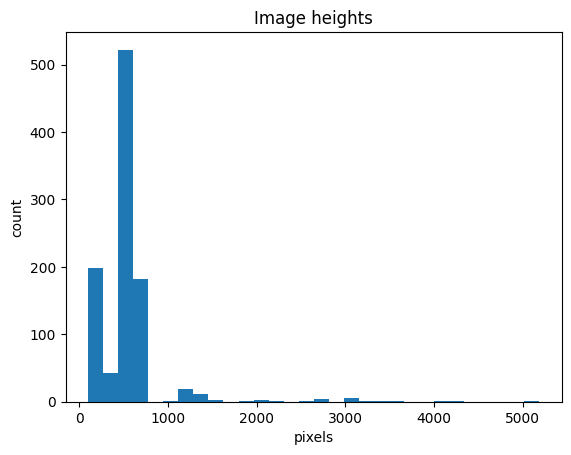

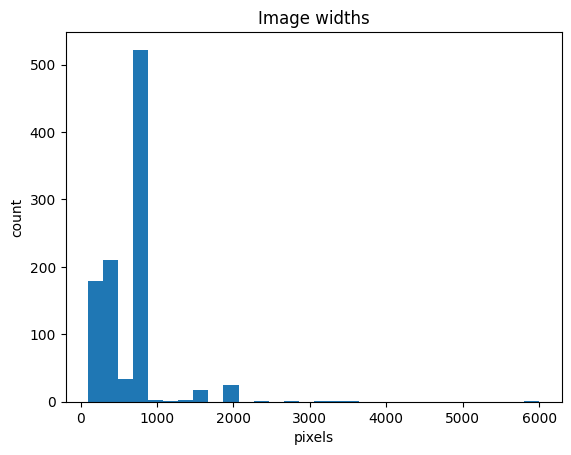

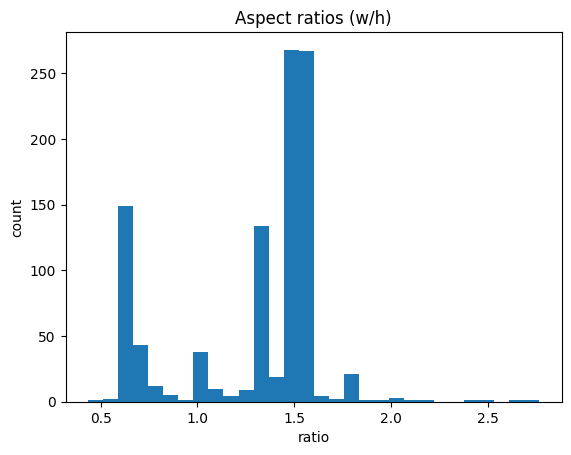

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(heights, bins=30)
plt.title("Image heights")
plt.xlabel("pixels")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(widths, bins=30)
plt.title("Image widths")
plt.xlabel("pixels")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(ratios, bins=30)
plt.title("Aspect ratios (w/h)")
plt.xlabel("ratio")
plt.ylabel("count")
plt.show()

In [28]:
class_names = sorted(train_df_full["label"].unique())
num_classes = len(class_names)
print("Classes:", class_names)
print("Num classes:", num_classes)

# Map label string → index
label2idx = {name: idx for idx, name in enumerate(class_names)}
idx2label = {idx: name for name, idx in label2idx.items()}

def add_label_idx(df):
    df = df.copy()
    df["label_idx"] = df["label"].map(label2idx)
    return df

train_df = add_label_idx(train_df)
val_df   = add_label_idx(val_df)
test_df  = add_label_idx(test_df)

Classes: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']
Num classes: 22


In [29]:
IMG_SIZE = (224, 224)
SHORT_SIDE = 256

def resize_shortest_side(image, short_side=SHORT_SIDE):
    """Resize so that the shortest side == short_side, keep aspect ratio."""
    shape = tf.cast(tf.shape(image)[:2], tf.float32)  # (h, w)
    h, w = shape[0], shape[1]
    scale = short_side / tf.minimum(h, w)
    new_h = tf.cast(h * scale, tf.int32)
    new_w = tf.cast(w * scale, tf.int32)
    image = tf.image.resize(image, [new_h, new_w])
    return image

def center_crop(image, target_height=IMG_SIZE[0], target_width=IMG_SIZE[1]):
    """Center crop to (target_height, target_width)."""
    shape = tf.shape(image)
    h, w = shape[0], shape[1]

    offset_h = tf.cast((h - target_height) / 2, tf.int32)
    offset_w = tf.cast((w - target_width) / 2, tf.int32)

    image = tf.image.crop_to_bounding_box(
        image,
        offset_h,
        offset_w,
        target_height,
        target_width,
    )
    return image

In [30]:
def load_and_preprocess_image(path):
    # path is a tf.string
    image_bytes = tf.io.read_file(path)
    # decode_image can handle jpg/png; set channels=3 for RGB
    image = tf.io.decode_image(image_bytes, channels=3, expand_animations=False)
    # convert to float32 in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    # resize shortest side and center crop
    image = resize_shortest_side(image, short_side=SHORT_SIDE)
    image = center_crop(image, target_height=IMG_SIZE[0], target_width=IMG_SIZE[1])

    # final shape: (224, 224, 3)
    image.set_shape((*IMG_SIZE, 3))
    return image

def preprocess_example(path, label_idx):
    image = load_and_preprocess_image(path)
    label = tf.cast(label_idx, tf.int32)
    return image, label

In [31]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

def df_to_dataset(df, shuffle=True):
    paths  = df["filepath"].values
    labels = df["label_idx"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(preprocess_example, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = df_to_dataset(train_df, shuffle=True)
val_ds   = df_to_dataset(val_df, shuffle=False)
test_ds  = df_to_dataset(test_df, shuffle=False)

In [32]:
for batch_images, batch_labels in train_ds.take(1):
    print("Images shape:", batch_images.shape)
    print("Labels shape:", batch_labels.shape)
    print("Pixel range:", float(tf.reduce_min(batch_images)), "→", float(tf.reduce_max(batch_images)))

Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Pixel range: 0.0 → 1.0


2025-11-22 12:36:35.768875: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


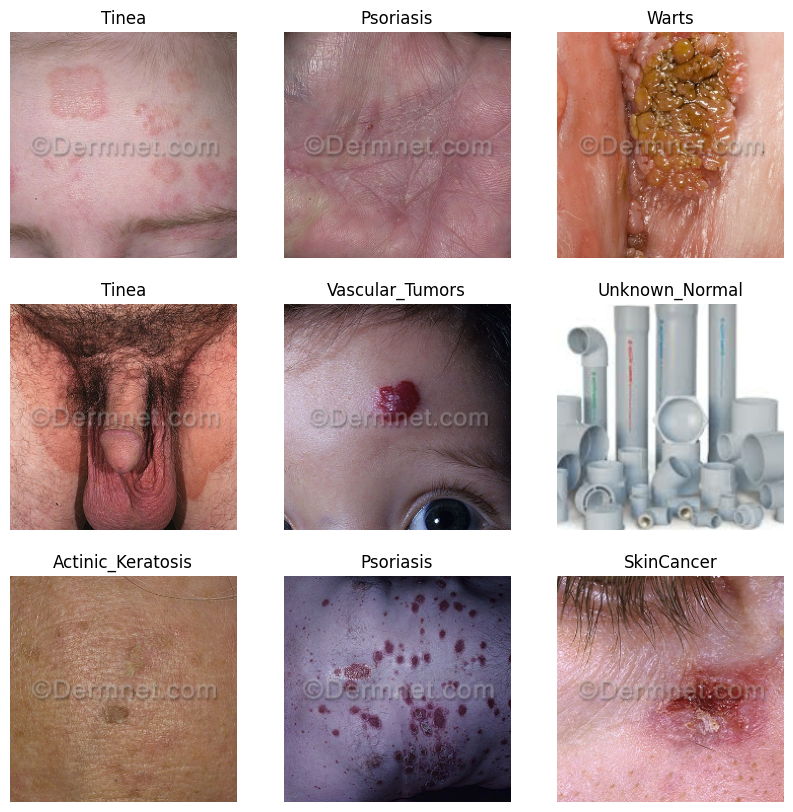

In [33]:
import matplotlib.pyplot as plt

def show_batch(ds, class_names, n=9):
    images, labels = next(iter(ds))
    plt.figure(figsize=(10, 10))
    for i in range(n):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

show_batch(train_ds, class_names)

In [34]:
from pathlib import Path
from google.colab import files

# Directory to store processed split CSVs
PROCESSED_DIR = Path("/content/processed_splits")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Save CSVs (you can rename however you like)
train_path = PROCESSED_DIR / "processed_train.csv"
val_path   = PROCESSED_DIR / "processed_val.csv"
test_path  = PROCESSED_DIR / "processed_test.csv"

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print("Saved:")
print(train_path)
print(val_path)
print(test_path)

# Download to your local machine
files.download(str(train_path))
files.download(str(val_path))
files.download(str(test_path))

ModuleNotFoundError: No module named 'google.colab'

TRAIN TOTAL: 13898
TEST TOTAL: 1546

--- TRAIN CLASS DISTRIBUTION ---
Acne                      593
Actinic_Keratosis         748
Benign_tumors             1093
Bullous                   504
Candidiasis               248
DrugEruption              547
Eczema                    1010
Infestations_Bites        524
Lichen                    553
Lupus                     311
Moles                     361
Psoriasis                 820
Rosacea                   254
Seborrh_Keratoses         455
SkinCancer                693
Sun_Sunlight_Damage       312
Tinea                     923
Unknown_Normal            1651
Vascular_Tumors           543
Vasculitis                461
Vitiligo                  714
Warts                     580

Most train samples: Unknown_Normal
Least train samples: Candidiasis
